# Neural network for classification with Ray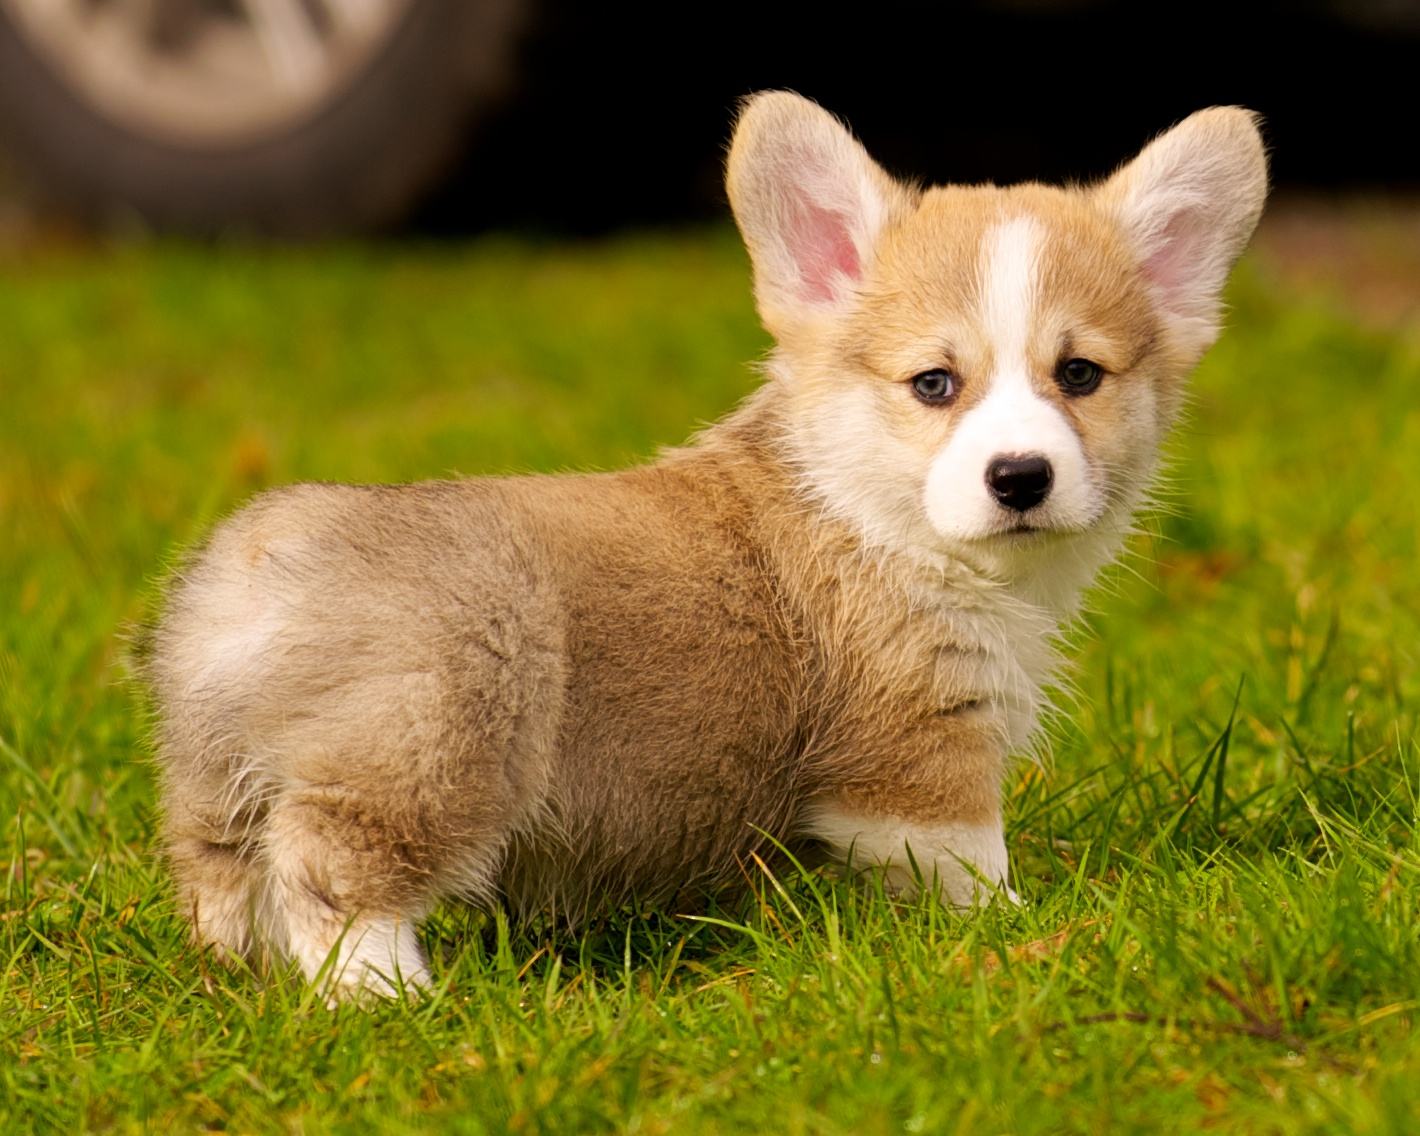

Dataset: [Dog Adaptability](https://www.kaggle.com/datasets/agarwalyashhh/dog-adaptability) \
Task: Classify dogs adaptability to live in an apartment based on their different traits \
Author: Aleksandra Smela | AGH University of Krakow \
April 2024

In [1]:
# !pip install ray[data]
# !pip install ray[train]
# !pip install ray[tune]
# !pip install -U tensorboardx
# !pip install torcheval

In [2]:
import ray
import numpy as np

## Data preprocessing

Using [Ray Data](https://docs.ray.io/en/latest/data/data.html)

In [34]:
ds = ray.data.read_csv("training_data.csv")

In [35]:
df=ds.to_pandas()

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
df.shape

(3200, 35)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               3200 non-null   int64  
 1   adaptability                     3200 non-null   int64  
 2   good_for_novice_owners           3200 non-null   int64  
 3   sensitivity_level                3181 non-null   float64
 4   tolerates_being_alone            3200 non-null   int64  
 5   tolerates_cold_weather           3200 non-null   int64  
 6   tolerates_hot_weather            3200 non-null   int64  
 7   all_around_friendliness          3200 non-null   int64  
 8   affectionate_with_family         3200 non-null   int64  
 9   incredibly_kifriendly_dogs       3200 non-null   int64  
 10  dog_friendly                     3200 non-null   int64  
 11  friendly_towarstrangers          3200 non-null   int64  
 12  health_grooming     

In [38]:
df.head()

,id,adaptability,good_for_novice_owners,sensitivity_level,tolerates_being_alone,tolerates_cold_weather,tolerates_hot_weather,all_around_friendliness,affectionate_with_family,incredibly_kifriendly_dogs,...,wanderlust_potential,exercise_needs,energy_level,intensity,potential_for_playfulness,breed_group,height,weight,lifspan,adapts_well_to_apartment_living
0,0,3,2,5.0,1,4,3,5,5,4,...,5,4.0,4,4.0,5,Mixed Breed Dogs,7 to 11 inches,70 to 115 pounds,10 to 15 years,Flexible
1,1,3,4,5.0,3,2,2,4,5,3,...,2,3.0,2,2.0,4,Companion Dogs,"2 feet to 2 feet, 4 inches tall at the shoulder",8 to 18 pounds,12 to 15 years,Moderate
2,2,4,3,5.0,3,4,4,5,5,5,...,3,4.0,5,1.0,4,Companion Dogs,23 to 27 inches tall at the shoulder,9 to 15 pounds,8 to 10 years,Versatile
3,3,3,2,3.0,3,4,4,4,5,5,...,4,4.0,5,4.0,4,Mixed Breed Dogs,10 to 13 inches,25 to 27 pounds,8 to 10 years,Resistant
4,4,3,3,2.0,3,3,2,3,4,3,...,3,3.0,3,3.0,3,Mixed Breed Dogs,21 to 25 inches at the shoulder,15 to 35 pounds,10 to 11 years,Versatile


In [39]:
ds.show(limit=5)

2024-04-21 20:02:18,977	INFO dataset.py:2370 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-04-21 20:02:18,998	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:19,001	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> LimitOperator[limit=5]


- ReadCSV->SplitBlocks(4) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=5 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'id': 0, 'adaptability': 3, 'good_for_novice_owners': 2, 'sensitivity_level': 5.0, 'tolerates_being_alone': 1, 'tolerates_cold_weather': 4, 'tolerates_hot_weather': 3, 'all_around_friendliness': 5, 'affectionate_with_family': 5, 'incredibly_kifriendly_dogs': 4, 'dog_friendly': 5, 'friendly_towarstrangers': 5, 'health_grooming': 2, 'amount_of_shedding': 5, 'drooling_potential': 4, 'easy_to_groom': 3, 'general_health': 3, 'potential_for_weight_gain': 2, 'size': 4, 'trainability': 4, 'easy_to_train': 4, 'intelligence': 4, 'potential_for_mouthiness': 4, 'prey_drive': 5.0, 'tendency_to_bark_or_howl': 4, 'wanderlust_potential': 5, 'exercise_needs': 4.0, 'energy_level': 4, 'intensity': 4.0, 'potential_for_playfulness': 5, 'breed_group': 'Mixed Breed Dogs', 'height': '7 to 11 inches', 'weight': '70 to 115 pounds', 'lifspan': '10 to 15 years', 'adapts_well_to_apartment_living': 'Flexible'}
{'id': 1, 'adaptability': 3, 'good_for_novice_owners': 4, 'sensitivity_level': 5.0, 'tolerates_being_alon

In [40]:
train_X, test_X = ds.train_test_split(test_size=0.2)
test_X, val_X = ds.train_test_split(test_size=0.5)
train_y=train_X.select_columns(['adapts_well_to_apartment_living'])
test_y=test_X.select_columns(['adapts_well_to_apartment_living'])
val_y=val_X.select_columns(['adapts_well_to_apartment_living'])

train_X=train_X.drop_columns(['adapts_well_to_apartment_living'])
test_X=test_X.drop_columns(['adapts_well_to_apartment_living'])
val_X=val_X.drop_columns(['adapts_well_to_apartment_living'])

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
import re
from ray.data.preprocessors import SimpleImputer, OneHotEncoder

def extract_height_avg(elem):
    matches = re.findall(r'\d+ (?!foot|feet)', elem)
    foot_matches = re.findall(r'\d+ foot', elem)+ re.findall(r'\d+ feet', elem)
    foot_matches = [re.findall(r'\d+', foot_match)[0] for foot_match in foot_matches]
    inches = [int(m) for m in matches] + [int(m)*12 for m in foot_matches]
    return (max(inches)-min(inches))/2

def extract_avg(elem):
    matches = re.findall(r'\d+', elem)
    inches = [int(m) for m in matches]
    return (max(inches)-min(inches))/2

def change_types(batch):
  batch=batch.astype(np.float32)
  return batch

In [42]:
imputer=SimpleImputer(columns=df.columns[df.isnull().any()], strategy='most_frequent')
train_X=imputer.fit_transform(train_X)
test_X=imputer.fit_transform(test_X)
val_X=imputer.fit_transform(val_X)

2024-04-21 20:02:37,056	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:37,057	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(drop_columns)->MapBatches(get_pd_value_counts)]


- MapBatches(drop_columns)->MapBatches(get_pd_value_counts) 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(drop_columns)->MapBatches(get_pd_value_counts) pid=66788) Could not construct Arrow block from numpy array; encountered values of unsupported numpy type `17` in column named 'sensitivity_level', which cannot be casted to an Arrow data type. Falling back to using pandas block type, which is slower and consumes more memory. For maximum performance, consider applying the following suggestions before ingesting into Ray Data in order to use native Arrow block types:
(MapBatches(drop_columns)->MapBatches(get_pd_value_counts) pid=66788) - Expand out each key-value pair in the dict column into its own column
(MapBatches(drop_columns)->MapBatches(get_pd_value_counts) pid=66788) - Replace `None` values with an Arrow supported data type
(MapBatches(drop_columns)->MapBatches(get_pd_value_counts) pid=66788) 
/usr/local/lib/python3.10/dist-packages/ray/data/preprocessor.py:111: UserWarning: `fit` has already been called on the preprocessor (or at least one contained preprocessors if this

- MapBatches(drop_columns)->MapBatches(get_pd_value_counts) 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ray/data/preprocessor.py:111: UserWarning: `fit` has already been called on the preprocessor (or at least one contained preprocessors if this is a chain). All previously fitted state will be overwritten!
  warnings.warn(
2024-04-21 20:02:37,618	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:37,624	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(drop_columns)->MapBatches(get_pd_value_counts)]


- MapBatches(drop_columns)->MapBatches(get_pd_value_counts) 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
train_X.add_column("height_avg", lambda df: extract_height_avg(df["height"]))
train_X.add_column("weight_avg", lambda df: extract_avg(df["weight"]))
train_X.add_column("lifspan_avg", lambda df: extract_avg(df["lifspan"]))

train_X=train_X.drop_columns(['id', 'weight', 'height', 'lifspan'])


test_X.add_column("height_avg", lambda df: extract_height_avg(df["height"]))
test_X.add_column("weight_avg", lambda df: extract_avg(df["weight"]))
test_X.add_column("lifspan_avg", lambda df: extract_avg(df["lifspan"]))

test_X=test_X.drop_columns(['id', 'weight', 'height', 'lifspan'])


val_X.add_column("height_avg", lambda df: extract_height_avg(df["height"]))
val_X.add_column("weight_avg", lambda df: extract_avg(df["weight"]))
val_X.add_column("lifspan_avg", lambda df: extract_avg(df["lifspan"]))

val_X=val_X.drop_columns(['id', 'weight', 'height', 'lifspan'])

In [44]:
encoder = OneHotEncoder(columns=df.drop(['id', 'adapts_well_to_apartment_living', 'height', 'weight', 'lifspan'], axis=1).columns.tolist())
train_X=encoder.fit_transform(train_X)
test_X=encoder.fit_transform(test_X)
val_X=encoder.fit_transform(val_X)

2024-04-21 20:02:38,587	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:38,591	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts)]


- MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts) 1:   0%| …

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts) pid=66788) Could not construct Arrow block from numpy array; encountered values of unsupported numpy type `17` in column named 'adaptability', which cannot be casted to an Arrow data type. Falling back to using pandas block type, which is slower and consumes more memory. For maximum performance, consider applying the following suggestions before ingesting into Ray Data in order to use native Arrow block types:
(MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts) pid=66788) - Expand out each key-value pair in the dict column into its own column
(MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts) pid=66788) - Replace `None` values with an Arrow supported data type
(MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts) pid=66788) 
/usr/local/lib/python3

- MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts) 1:   0%| …

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ray/data/preprocessor.py:111: UserWarning: `fit` has already been called on the preprocessor (or at least one contained preprocessors if this is a chain). All previously fitted state will be overwritten!
  warnings.warn(
2024-04-21 20:02:39,454	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:39,459	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts)]


- MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->MapBatches(get_pd_value_counts) 1:   0%| …

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

In [45]:
encoder = OneHotEncoder(columns=["adapts_well_to_apartment_living"])
train_y=encoder.fit_transform(train_y)
test_y=encoder.fit_transform(test_y)
val_y=encoder.fit_transform(val_y)

2024-04-21 20:02:40,103	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:40,106	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(fn)->MapBatches(get_pd_value_counts)]


- MapBatches(fn)->MapBatches(get_pd_value_counts) 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(fn)->MapBatches(get_pd_value_counts) pid=66788) Could not construct Arrow block from numpy array; encountered values of unsupported numpy type `17` in column named 'adapts_well_to_apartment_living', which cannot be casted to an Arrow data type. Falling back to using pandas block type, which is slower and consumes more memory. For maximum performance, consider applying the following suggestions before ingesting into Ray Data in order to use native Arrow block types:
(MapBatches(fn)->MapBatches(get_pd_value_counts) pid=66788) - Expand out each key-value pair in the dict column into its own column
(MapBatches(fn)->MapBatches(get_pd_value_counts) pid=66788) - Replace `None` values with an Arrow supported data type
(MapBatches(fn)->MapBatches(get_pd_value_counts) pid=66788) 
/usr/local/lib/python3.10/dist-packages/ray/data/preprocessor.py:111: UserWarning: `fit` has already been called on the preprocessor (or at least one contained preprocessors if this is a chain). All previous

- MapBatches(fn)->MapBatches(get_pd_value_counts) 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ray/data/preprocessor.py:111: UserWarning: `fit` has already been called on the preprocessor (or at least one contained preprocessors if this is a chain). All previously fitted state will be overwritten!
  warnings.warn(
2024-04-21 20:02:41,307	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:41,311	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(fn)->MapBatches(get_pd_value_counts)]


- MapBatches(fn)->MapBatches(get_pd_value_counts) 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

In [46]:
train_X=train_X.map_batches(change_types, batch_format="pandas")
test_X=test_X.map_batches(change_types, batch_format="pandas")
val_X=val_X.map_batches(change_types, batch_format="pandas")

In [47]:
df_train_X=train_X.to_pandas()
df_test_X=test_X.to_pandas()
df_val_X=val_X.to_pandas()

df_train_y=train_y.to_pandas()
df_test_y=test_y.to_pandas()
df_val_y=val_y.to_pandas()

2024-04-21 20:02:43,913	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:43,916	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->OneHotEncoder->MapBatches(change_types)]


- MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->OneHotEncoder->MapBatches(change_types) 1…

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->OneHotEncoder->MapBatches(change_types) pid=66788) /usr/local/lib/python3.10/dist-packages/ray/data/preprocessors/encoder.py:230: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
(MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->OneHotEncoder->MapBatches(change_types) pid=66788)   df[f"{column}_{column_value}"] = (df[column] == column_value).astype(
(MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->OneHotEncoder->MapBatches(change_types) pid=66788) /usr/local/lib/python3.10/dist-packages/ray/data/preprocessors/encoder.py:230: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

- MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->OneHotEncoder->MapBatches(change_types) 1…

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

2024-04-21 20:02:45,509	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:45,512	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->OneHotEncoder->MapBatches(change_types)]


- MapBatches(drop_columns)->SimpleImputer->MapBatches(drop_columns)->OneHotEncoder->MapBatches(change_types) 1…

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

2024-04-21 20:02:46,260	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:46,263	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(fn)->OneHotEncoder]


- MapBatches(fn)->OneHotEncoder 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-04-21 20:02:46,576	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:46,578	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(fn)->OneHotEncoder]


- MapBatches(fn)->OneHotEncoder 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

2024-04-21 20:02:46,856	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-21_19-46-40_408216_62232/logs
2024-04-21 20:02:46,860	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(fn)->OneHotEncoder]


- MapBatches(fn)->OneHotEncoder 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

In [48]:
df_train_X.shape

(2560, 145)

In [49]:
df_train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Columns: 145 entries, adaptability_2 to breed_group_Working Dogs
dtypes: float32(145)
memory usage: 1.4 MB


In [50]:
df_train_X.head()

,adaptability_2,adaptability_3,adaptability_4,good_for_novice_owners_1,good_for_novice_owners_2,good_for_novice_owners_3,good_for_novice_owners_4,good_for_novice_owners_5,sensitivity_level_2.0,sensitivity_level_3.0,...,potential_for_playfulness_4,potential_for_playfulness_5,breed_group_Companion Dogs,breed_group_Herding Dogs,breed_group_Hound Dogs,breed_group_Hybrid Dogs,breed_group_Mixed Breed Dogs,breed_group_Sporting Dogs,breed_group_Terrier Dogs,breed_group_Working Dogs
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [51]:
df_test_X.shape

(1600, 145)

In [52]:
df_test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Columns: 145 entries, adaptability_2 to breed_group_Working Dogs
dtypes: float32(145)
memory usage: 906.4 KB


In [53]:
df_test_X.head()

,adaptability_2,adaptability_3,adaptability_4,good_for_novice_owners_1,good_for_novice_owners_2,good_for_novice_owners_3,good_for_novice_owners_4,good_for_novice_owners_5,sensitivity_level_2.0,sensitivity_level_3.0,...,potential_for_playfulness_4,potential_for_playfulness_5,breed_group_Companion Dogs,breed_group_Herding Dogs,breed_group_Hound Dogs,breed_group_Hybrid Dogs,breed_group_Mixed Breed Dogs,breed_group_Sporting Dogs,breed_group_Terrier Dogs,breed_group_Working Dogs
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Training

Using [Ray Train](https://docs.ray.io/en/latest/train/train.html)

In [23]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import MulticlassAccuracy, MulticlassF1Score
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import TuneConfig
import ray.train.torch

class Data(Dataset):
  def __init__(self, train_X, train_y):
    self.X = torch.tensor(train_X.values)
    self.y = torch.tensor(train_y.values.argmax(axis=1))
    self.len = self.X.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.len

# number of features (len of X cols)
input_dim = df_train_X.shape[1]
# number of classes (unique of y)
output_dim = df_train_y.shape[1]

class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.linear1 = nn.Linear(input_dim, input_dim*2)
    self.linear2 = nn.Linear(input_dim*2, output_dim)
    self.act = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self, x):
    x = self.act(self.linear1(x))
    x = self.linear2(x)
    x=self.softmax(x)
    return x

In [24]:
def train_func(config):
  val_metrics=dict()

  clf = ray.train.torch.prepare_model(Network())
  criterion = nn.CrossEntropyLoss()
  optimizer = SGD(clf.parameters(), lr=config['lr'], momentum=config['momentum'])

  multicl_acc_metric_train = MulticlassAccuracy()
  f1_metric_train= MulticlassF1Score()
  multicl_acc_metric_val = MulticlassAccuracy()
  f1_metric_val= MulticlassF1Score()

  train_data = Data(df_train_X, df_train_y)
  train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
  train_loader = ray.train.torch.prepare_data_loader(train_loader)

  val_data=Data(df_val_X, df_val_y)

  for epoch in range(200):
    if ray.train.get_context().get_world_size() > 1:
      train_loader.sampler.set_epoch(epoch)

    for i, data in enumerate(train_loader, 0):
      clf.train()
      inputs, labels = data
      optimizer.zero_grad()
      outputs = clf(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

    if epoch%10==0:
      class_predictions=torch.argmax(outputs, dim=1)
      multicl_acc_metric_train.update(class_predictions, labels)
      f1_metric_train.update(class_predictions, labels)

      clf.eval()
      with torch.no_grad():
        pred = clf(val_data.X)
        valid_loss = criterion(pred, val_data.y)
        class_predictions=torch.argmax(outputs, dim=1)
        multicl_acc_metric_val.update(class_predictions, labels)
        f1_metric_val.update(class_predictions, labels)
        val_metrics={"val_loss": round(loss.item(),4), "val_accuracy":round(multicl_acc_metric_val.compute().item(),4), "val_f1":round(f1_metric_val.compute().item(),4), "train_loss": round(loss.item(),4), "train_accuracy":round(multicl_acc_metric_train.compute().item(),4), "train_f1":round(f1_metric_train.compute().item(),4)}

      train.report(val_metrics, checkpoint=None)

In [32]:
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig

scaling_config = ScalingConfig(num_workers=2)
trainer = TorchTrainer(train_func, scaling_config=scaling_config, train_loop_config={"lr":0.3, "momentum":0})

In [33]:
result=trainer.fit()

2024-04-21 19:50:12,679	INFO tune.py:633 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949



View detailed results here: /root/ray_results/TorchTrainer_2024-04-21_19-50-12
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-21_19-46-40_408216_62232/artifacts/2024-04-21_19-50-12/TorchTrainer_2024-04-21_19-50-12/driver_artifacts`

Training started with configuration:
+----------------------------------+
| Training config                  |
+----------------------------------+
| train_loop_config/lr         0.3 |
| train_loop_config/momentum     0 |
+----------------------------------+


(TorchTrainer pid=63819) Started distributed worker processes: 
(TorchTrainer pid=63819) - (ip=172.28.0.12, pid=63888) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=63819) - (ip=172.28.0.12, pid=63893) world_rank=1, local_rank=1, node_rank=0
(RayTrainWorker pid=63888) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=63893) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(RayTrainWorker pid=63893)   return self._call_impl(*args, **kwargs)
(RayTrainWorker pid=63888) Moving model to device: cpu
(RayTrainWorker pid=63888) Wrapping provided model in DistributedDataParallel.



Training finished iteration 1 at 2024-04-21 19:50:35. Total running time: 22s
+-------------------------------+
| Training result               |
+-------------------------------+
| checkpoint_dir_name           |
| time_this_iter_s      13.1154 |
| time_total_s          13.1154 |
| training_iteration          1 |
| train_accuracy          0.275 |
| train_f1                0.275 |
| train_loss             1.5991 |
| val_accuracy            0.275 |
| val_f1                  0.275 |
| val_loss               1.5991 |
+-------------------------------+

Training finished iteration 2 at 2024-04-21 19:50:36. Total running time: 23s
+-------------------------------+
| Training result               |
+-------------------------------+
| checkpoint_dir_name           |
| time_this_iter_s      0.79528 |
| time_total_s          13.9107 |
| training_iteration          2 |
| train_accuracy         0.4187 |
| train_f1               0.4187 |
| train_loss             1.3597 |
| val_accuracy           0

2024-04-21 19:50:58,183	INFO tune.py:1021 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/TorchTrainer_2024-04-21_19-50-12' in 0.0112s.



Training completed after 20 iterations at 2024-04-21 19:50:58. Total running time: 45s



## Tuning

Using [Ray Tune](https://docs.ray.io/en/latest/tune/index.html)

In [27]:
def train_func_pure(config):
  val_metrics=dict()

  clf = Network()
  criterion = nn.CrossEntropyLoss()
  optimizer = SGD(clf.parameters(), lr=config['lr'], momentum=config['momentum'])

  multicl_acc_metric_train = MulticlassAccuracy()
  f1_metric_train= MulticlassF1Score()
  multicl_acc_metric_val = MulticlassAccuracy()
  f1_metric_val= MulticlassF1Score()

  train_data = Data(df_train_X, df_train_y)
  train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

  val_data=Data(df_val_X, df_val_y)

  for epoch in range(200):
    for i, data in enumerate(train_loader, 0):
      clf.train()
      inputs, labels = data
      optimizer.zero_grad()
      outputs = clf(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

    if epoch%10==0:
      class_predictions=torch.argmax(outputs, dim=1)
      multicl_acc_metric_train.update(class_predictions, labels)
      f1_metric_train.update(class_predictions, labels)

      clf.eval()
      with torch.no_grad():
        pred = clf(val_data.X)
        valid_loss = criterion(pred, val_data.y)
        class_predictions=torch.argmax(outputs, dim=1)
        multicl_acc_metric_val.update(class_predictions, labels)
        f1_metric_val.update(class_predictions, labels)
        val_metrics={"val_loss": round(loss.item(),4), "val_accuracy":round(multicl_acc_metric_val.compute().item(),4), "val_f1":round(f1_metric_val.compute().item(),4), "train_loss": round(loss.item(),4), "train_accuracy":round(multicl_acc_metric_train.compute().item(),4), "train_f1":round(f1_metric_train.compute().item(),4)}

  return val_metrics

In [28]:
def trainable(config):
  final_metric = train_func_pure(config)
  train.report(final_metric)

In [29]:
search_space = {
    "lr": tune.uniform(0.1, 0.9),
    "momentum": tune.uniform(0.001, 0.5),
}

tune_config=TuneConfig(metric="val_accuracy", mode = 'max', num_samples = 5, time_budget_s =360)

tuner = tune.Tuner(
    trainable,
    param_space=search_space,
    tune_config=tune_config
)

In [30]:
results = tuner.fit()

2024-04-21 19:47:17,716	INFO tune.py:633 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+------------------------------------------------------------------+
| Configuration for experiment     trainable_2024-04-21_19-47-17   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        FIFOScheduler                   |
| Number of trials                 5                               |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/trainable_2024-04-21_19-47-17
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-21_19-46-40_408216_62232/artifacts/2024-04-21_19-47-17/trainable_2024-04-21_19-47-17/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-21 19:47:18. Total running time: 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------+
| Trial name              status           lr     mo

(trainable pid=62863) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(trainable pid=62863)   return self._call_impl(*args, **kwargs)



Trial status: 2 RUNNING | 3 PENDING
Current time: 2024-04-21 19:47:48. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------+
| Trial name              status           lr     momentum |
+----------------------------------------------------------+
| trainable_f5b00_00000   RUNNING    0.583775    0.0759396 |
| trainable_f5b00_00001   RUNNING    0.352571    0.0464378 |
| trainable_f5b00_00002   PENDING    0.594827    0.0749239 |
| trainable_f5b00_00003   PENDING    0.589292    0.42336   |
| trainable_f5b00_00004   PENDING    0.76855     0.468928  |
+----------------------------------------------------------+

Trial trainable_f5b00_00000 completed after 1 iterations at 2024-04-21 19:48:04. Total running time: 46s
+------------------------------------------------+
| Trial trainable_f5b00_00000 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |


(trainable pid=63187) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 2x across cluster]
(trainable pid=63187)   return self._call_impl(*args, **kwargs) [repeated 2x across cluster]



Trial trainable_f5b00_00003 started with configuration:
+------------------------------------------------+
| Trial trainable_f5b00_00003 config             |
+------------------------------------------------+
| lr                                     0.58929 |
| momentum                               0.42336 |
+------------------------------------------------+

Trial trainable_f5b00_00002 completed after 1 iterations at 2024-04-21 19:48:47. Total running time: 1min 29s
+-----------------------------------------------+
| Trial trainable_f5b00_00002 result            |
+-----------------------------------------------+
| checkpoint_dir_name                           |
| time_this_iter_s                       27.782 |
| time_total_s                           27.782 |
| training_iteration                          1 |
| train_accuracy                          0.705 |
| train_f1                                0.705 |
| train_loss                             1.1193 |
| val_accuracy            

(trainable pid=63444) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 2x across cluster]
(trainable pid=63444)   return self._call_impl(*args, **kwargs) [repeated 2x across cluster]
2024-04-21 19:49:14,384	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-21 19:49:14,398	INFO tune.py:1021 -- Wrote the latest version of a


Trial trainable_f5b00_00004 completed after 1 iterations at 2024-04-21 19:49:14. Total running time: 1min 56s
+------------------------------------------------+
| Trial trainable_f5b00_00004 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       16.1515 |
| time_total_s                           16.1515 |
| training_iteration                           1 |
| train_accuracy                            0.78 |
| train_f1                                  0.78 |
| train_loss                              1.0184 |
| val_accuracy                              0.78 |
| val_f1                                    0.78 |
| val_loss                                1.0184 |
+------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-21 19:49:14. Total running time: 1min 56s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: f5b00_00004 with v

## Conclusions

* Using Ray may significantly speed up data preprocessing, training and validation - especially if there is multiple CPUs or GPUs to utilize. In this case I used only 2 CPUs, so the performance boost was not visible that much.
* The results are fine for the amount of experiments. What definitely helped was using one hot encoding for features represented numerical "levels" ex. size.
* I encountered problems with integrating Ray modules. I did not manage to build a smooth pipeline between data preprocessing, training and tuning. All those parts are somehow separate ex. data needs to be preprocessed and converted to pandas dataframe to be later used in training part.
* I chose to build a neural network classification model because of Ray's support for pytorch. Otherwise I would use dedicated classifiers implementations from for example sklearn. Ray's implementation for Joblib (to support scikit-learn) is still to be discoverd.
* Support of well known libraries (numpy, pandas and pytorch) definitely helped to convert project to Ray.
* Future work: implement distributed program using Ray and classifiers from scikit-learn, more charts and result analysis (however Ray's reports are great).




